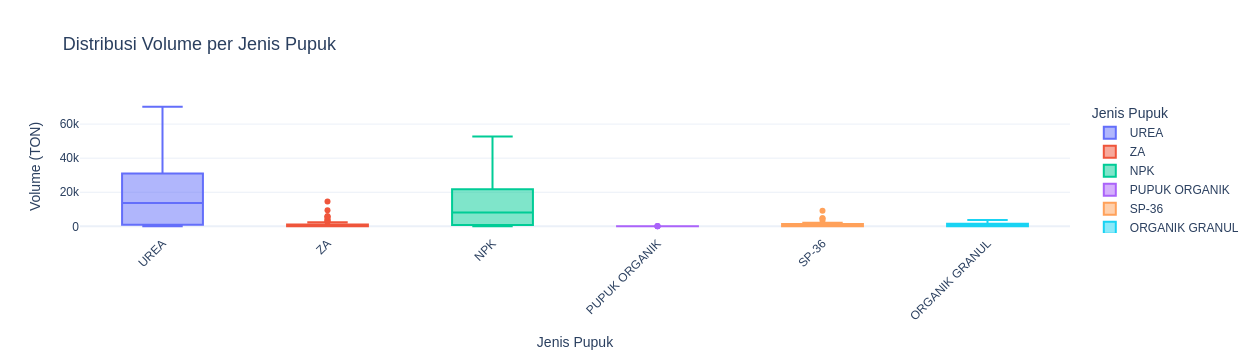

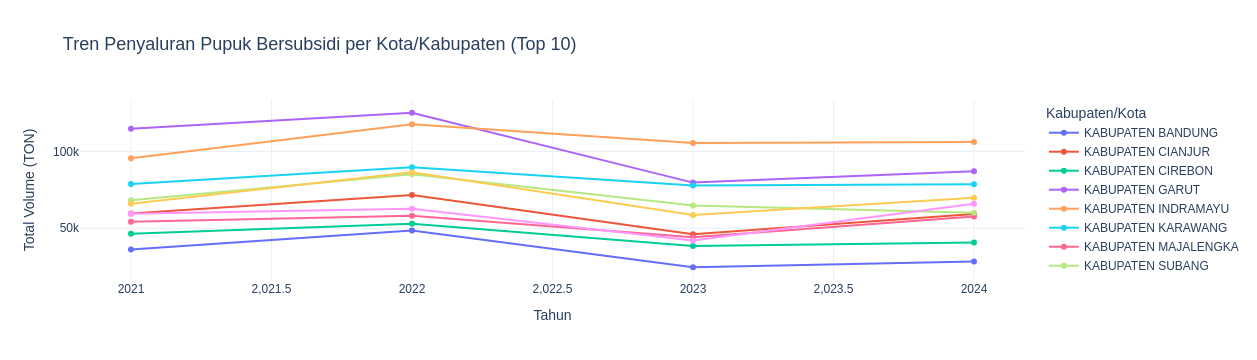

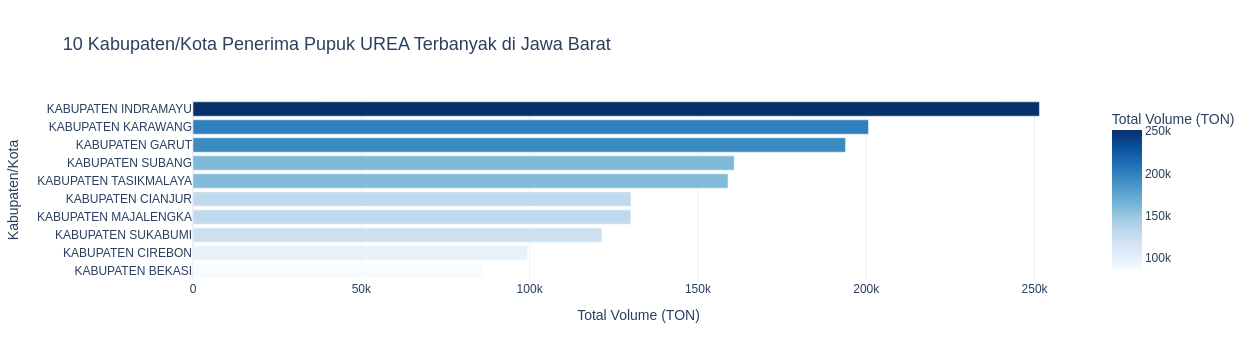

   nama_kabupaten_kota  tahun   volume     delta
73        KOTA BANDUNG   2022  48499.3  48138.04


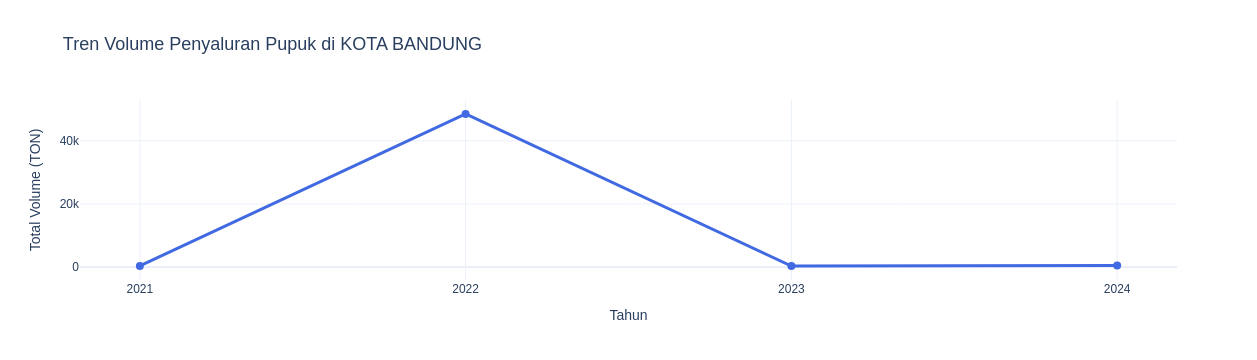

     volume  volume_normalized
0  13997.76           0.199285
1    611.57           0.008707
2   9248.44           0.131669
3  30280.38           0.431100
4    784.26           0.011165
     volume  volume_standardized
0  13997.76             0.280098
1    611.57            -0.639174
2   9248.44            -0.046053
3  30280.38             1.398276
4    784.26            -0.627315
        jenis_pupuk  jenis_pupuk_encoded
0              UREA                    4
1                ZA                    5
2               NPK                    0
137   PUPUK ORGANIK                    2
217           SP-36                    3
220  ORGANIK GRANUL                    1
Index(['id', 'kode_provinsi', 'nama_provinsi', 'kode_kabupaten_kota',
       'nama_kabupaten_kota', 'volume', 'satuan', 'tahun',
       'jenis_pupuk_encoded', 'jenis_pupuk_NPK', 'jenis_pupuk_ORGANIK GRANUL',
       'jenis_pupuk_PUPUK ORGANIK', 'jenis_pupuk_SP-36', 'jenis_pupuk_UREA',
       'jenis_pupuk_ZA'],
      dtype='objec

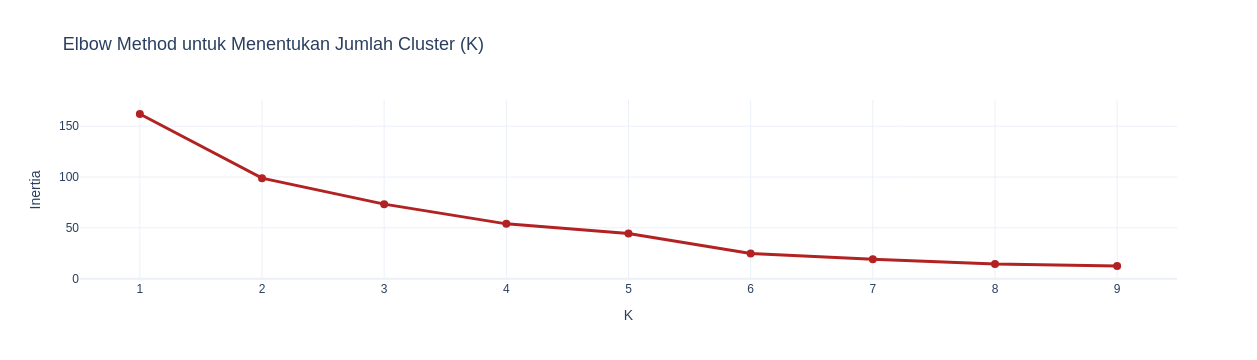

jenis_pupuk         NPK  ORGANIK GRANUL  PUPUK ORGANIK        SP-36  \
cluster                                                               
0             25629.790      329.990556      24.761111   288.572222   
1            129998.050     2767.445000      35.192500   677.097500   
2             81436.358     1252.302000      12.640000  4752.350000   

jenis_pupuk           UREA            ZA  cluster  
cluster                                            
0             35566.347222    793.222889      0.0  
1            192956.345000    882.032500      1.0  
2            110997.566000  10535.564000      2.0  


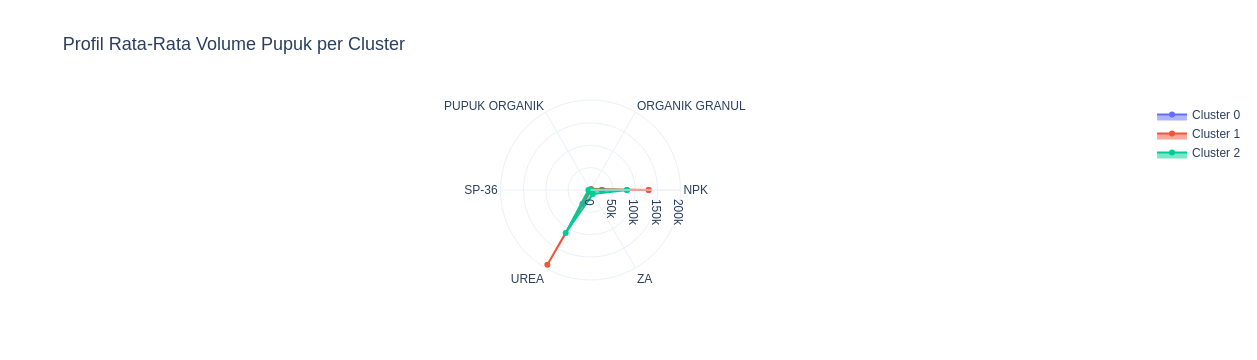

00:26:41 - cmdstanpy - INFO - Chain [1] start processing
00:26:41 - cmdstanpy - INFO - Chain [1] done processing


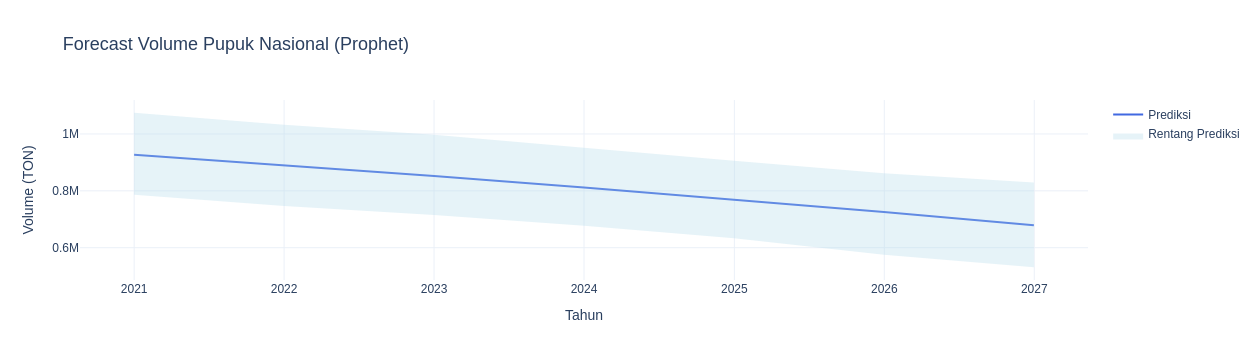

In [5]:
# 1. IMPORT LIBRARY
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
sns.set_context('paper')
sns.set_style('whitegrid')
sns.set_palette('Spectral')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']  # atau Arial, Roboto, dsb


df = pd.read_csv("distanhor-od_18713_jml_penyaluran_pupuk_bersubsidi__kabupatenkota_jen_v2_data.csv")

df.head()
df.shape
df.duplicated(['volume']).sum()


fig = px.box(df, 
             x='jenis_pupuk', 
             y='volume', 
             color='jenis_pupuk',  # biar warnanya beda
             title='Distribusi Volume per Jenis Pupuk',
             labels={'jenis_pupuk': 'Jenis Pupuk', 'volume': 'Volume (TON)'},
             template='plotly_white')  # gaya visual bersih

fig.update_layout(
    xaxis_tickangle=-45,
    title_font_size=18
)

fig.show()

# Agregasi total volume per tahun per provinsi
volume_per_tahun_prov = df.groupby(['tahun', 'nama_provinsi'])['volume'].sum().reset_index()
# Grouping data berdasarkan tahun dan kabupaten/kota
volume_per_kota = df.groupby(['tahun', 'nama_kabupaten_kota'])['volume'].sum().reset_index()

# Pilih beberapa kota dengan total volume terbesar agar visualisasi tidak terlalu ramai
top_kota = volume_per_kota.groupby('nama_kabupaten_kota')['volume'].sum().nlargest(10).index
filtered = volume_per_kota[volume_per_kota['nama_kabupaten_kota'].isin(top_kota)]


fig = px.line(
    filtered,
    x='tahun',
    y='volume',
    color='nama_kabupaten_kota',
    markers=True,
    title='Tren Penyaluran Pupuk Bersubsidi per Kota/Kabupaten (Top 10)',
    labels={
        'volume': 'Total Volume (TON)',
        'tahun': 'Tahun',
        'nama_kabupaten_kota': 'Kabupaten/Kota'
    },
    template='plotly_white'
)

fig.update_layout(
    title_font_size=18,
    legend_title_text='Kabupaten/Kota',
    legend=dict(x=1.02, y=1, xanchor='left', yanchor='top')
)

fig.show()

# Filter data hanya untuk pupuk UREA
urea_df = df[df['jenis_pupuk'] == 'UREA']

# Kelompokkan berdasarkan kota/kabupaten dan jumlahkan volume
top_kabupaten_urea = urea_df.groupby('nama_kabupaten_kota')['volume'].sum().sort_values(ascending=False).reset_index()

# Tampilkan 10 kabupaten/kota teratas
top_kabupaten_urea.head(10)

# Ambil 10 besar
top10 = top_kabupaten_urea.head(10)

import plotly.express as px

fig = px.bar(
    top10,
    x='volume',
    y='nama_kabupaten_kota',
    orientation='h',
    color='volume',
    color_continuous_scale='Blues',
    title='10 Kabupaten/Kota Penerima Pupuk UREA Terbanyak di Jawa Barat',
    labels={
        'volume': 'Total Volume (TON)',
        'nama_kabupaten_kota': 'Kabupaten/Kota'
    },
    template='plotly_white'
)

fig.update_layout(
    title_font_size=18,
    yaxis=dict(autorange="reversed")  # agar urutan sama seperti barplot seaborn
)

fig.show()

# Agregasi volume per kota dan tahun
volume_per_kota_tahun = df.groupby(['nama_kabupaten_kota', 'tahun'])['volume'].sum().reset_index()

# Urutkan per kota dan tahun
volume_per_kota_tahun.sort_values(by=['nama_kabupaten_kota', 'tahun'], inplace=True)

# Hitung perubahan volume per kota (YoY)
volume_per_kota_tahun['delta'] = volume_per_kota_tahun.groupby('nama_kabupaten_kota')['volume'].diff()

# Cari kenaikan terbesar
max_increase = volume_per_kota_tahun.sort_values(by='delta', ascending=False).head(1)

print(max_increase)

# Step 1: Agregasi volume per kota dan tahun
volume_per_kota_tahun = df.groupby(['nama_kabupaten_kota', 'tahun'])['volume'].sum().reset_index()

# Step 2: Hitung kenaikan YoY
volume_per_kota_tahun.sort_values(by=['nama_kabupaten_kota', 'tahun'], inplace=True)
volume_per_kota_tahun['delta'] = volume_per_kota_tahun.groupby('nama_kabupaten_kota')['volume'].diff()

# Step 3: Ambil kota dengan kenaikan terbesar
top_rise = volume_per_kota_tahun.sort_values(by='delta', ascending=False).head(1)
top_kabupaten = top_rise['nama_kabupaten_kota'].values[0]

# Step 4: Ambil data lengkap kabupaten tersebut
top_kabupaten_data = volume_per_kota_tahun[volume_per_kota_tahun['nama_kabupaten_kota'] == top_kabupaten]


import plotly.express as px

fig = px.line(
    top_kabupaten_data,
    x='tahun',
    y='volume',
    markers=True,
    title=f'Tren Volume Penyaluran Pupuk di {top_kabupaten}',
    labels={'volume': 'Total Volume (TON)', 'tahun': 'Tahun'},
    template='plotly_white'
)

fig.update_traces(line=dict(color='royalblue', width=3), marker=dict(size=8))
fig.update_layout(
    title_font_size=18,
    xaxis=dict(dtick=1),
    showlegend=False
)

fig.show()

from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Salin dataframe untuk transformasi
df_normalized = df.copy()
df_standardized = df.copy()

# Inisialisasi scaler
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Normalisasi
df_normalized['volume_normalized'] = min_max_scaler.fit_transform(df[['volume']])

# Standarisasi
df_standardized['volume_standardized'] = standard_scaler.fit_transform(df[['volume']])

# Tampilkan 5 baris pertama
print(df_normalized[['volume', 'volume_normalized']].head())
print(df_standardized[['volume', 'volume_standardized']].head())


from sklearn.preprocessing import LabelEncoder

# Inisialisasi dan terapkan LabelEncoder
le = LabelEncoder()
df['jenis_pupuk_encoded'] = le.fit_transform(df['jenis_pupuk'])

# Lihat hasil
print(df[['jenis_pupuk', 'jenis_pupuk_encoded']].drop_duplicates())


# Menggunakan pandas get_dummies
df_onehot = pd.get_dummies(df, columns=['jenis_pupuk'])

# Cek kolom hasil encoding
print(df_onehot.columns)


from sklearn.model_selection import train_test_split

# Misal kamu punya fitur berikut:
# Fitur input: lokasi (encoded), jenis_pupuk (encoded), tahun
# Target: volume

# Fitur dan target
X = df[['kode_kabupaten_kota', 'jenis_pupuk_encoded', 'tahun']]
y = df['volume']

# Split data 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X = fitur, y = target
X = df[['kode_kabupaten_kota', 'jenis_pupuk_encoded', 'tahun']]
y = df['volume']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Inisialisasi model
lr_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42)

# Training
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prediksi
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Evaluasi
def evaluate(y_true, y_pred, model_name):
    print(f"=== {model_name} ===")
    print("MAE :", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R²  :", r2_score(y_true, y_pred))
    print()

evaluate(y_test, y_pred_lr, "Linear Regression")
evaluate(y_test, y_pred_rf, "Random Forest")

# Buat pivot table: rows = kabupaten, columns = jenis pupuk, values = total volume
pivot_df = df.pivot_table(
    index='nama_kabupaten_kota',
    columns='jenis_pupuk',
    values='volume',
    aggfunc='sum',
    fill_value=0
).reset_index()

# Drop kolom kota untuk clustering, simpan untuk identifikasi hasil
kabupaten_nama = pivot_df['nama_kabupaten_kota']
X_clustering = pivot_df.drop(columns='nama_kabupaten_kota')

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

from sklearn.cluster import KMeans

inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)


#plot
import plotly.express as px
import pandas as pd

# Siapkan data sebagai DataFrame agar mudah pakai Plotly
elbow_df = pd.DataFrame({
    'Jumlah Cluster': range(1, 10),
    'Inertia': inertia
})

# Plot
fig = px.line(
    elbow_df,
    x='Jumlah Cluster',
    y='Inertia',
    markers=True,
    title='Elbow Method untuk Menentukan Jumlah Cluster (K)',
    labels={'Inertia': 'Inertia', 'Jumlah Cluster': 'K'},
    template='plotly_white'
)

fig.update_traces(line=dict(color='firebrick', width=3), marker=dict(size=8))
fig.update_layout(title_font_size=18, xaxis=dict(dtick=1))
fig.show()

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Tambahkan hasil cluster ke dataset asli
pivot_df['cluster'] = cluster_labels

# Contoh tampilan hasil
pivot_df[['nama_kabupaten_kota', 'cluster']].head()

# Cek statistik per cluster

# Hanya ambil kolom numerik + 'cluster'
numerik_columns = pivot_df.drop(columns='nama_kabupaten_kota').select_dtypes(include='number')

# Hitung rata-rata fitur per cluster
cluster_stats = numerik_columns.groupby(pivot_df['cluster']).mean()
print(cluster_stats)

# Gunakan data cluster stats dari sebelumnya
cluster_stats = numerik_columns.groupby(pivot_df['cluster']).mean()

# Buat radar chart
labels = cluster_stats.columns[:-1]  # Exclude cluster column
num_vars = len(labels)

# Hitung sudut untuk setiap axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Tambah titik akhir untuk loop
angles += angles[:1]

import plotly.graph_objects as go

# Siapkan data
labels = cluster_stats.columns[:-1]  # Hapus kolom 'cluster' kalau ada
clusters = cluster_stats.index.tolist()

# Buat list trace (satu trace per cluster)
fig = go.Figure()

for i, cluster in enumerate(clusters):
    values = cluster_stats.iloc[i][labels].tolist()
    values += [values[0]]  # Tutup loop
    
    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=list(labels) + [labels[0]],
        fill='toself',
        name=f'Cluster {cluster}',
        line=dict(width=2)
    ))

# Layout
fig.update_layout(
    polar=dict(
        radialaxis=dict(visible=True),
    ),
    template='plotly_white',
    title='Profil Rata-Rata Volume Pupuk per Cluster',
    title_font_size=18,
    legend=dict(x=1.05, y=1)
)

fig.show()

# Step 1: Agregasi data per tahun
ts_df = df.groupby('tahun')['volume'].sum().reset_index()
ts_df.columns = ['ds', 'y']  # Rename kolom sesuai format Prophet

# Step 2: Ubah tahun ke format datetime
ts_df['ds'] = pd.to_datetime(ts_df['ds'], format='%Y')

# Step 3: Inisialisasi model
model = Prophet()
model.fit(ts_df)

# Step 4: Buat future dataframe 3 tahun ke depan
future = model.make_future_dataframe(periods=3, freq='Y')

# Step 5: Prediksi
forecast = model.predict(future)

import plotly.graph_objects as go

# Buat figure
fig = go.Figure()

# Tambahkan garis prediksi utama
fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat'],
    mode='lines',
    name='Prediksi',
    line=dict(color='royalblue')
))

# Tambahkan area prediksi bawah-atas
fig.add_trace(go.Scatter(
    x=forecast['ds'].tolist() + forecast['ds'][::-1].tolist(),
    y=forecast['yhat_upper'].tolist() + forecast['yhat_lower'][::-1].tolist(),
    fill='toself',
    fillcolor='rgba(173,216,230,0.3)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    showlegend=True,
    name='Rentang Prediksi'
))

# Layout
fig.update_layout(
    title='Forecast Volume Pupuk Nasional (Prophet)',
    xaxis_title='Tahun',
    yaxis_title='Volume (TON)',
    template='plotly_white',
    title_font_size=18,
    hovermode='x unified'
)

fig.show()

from prophet.diagnostics import cross_validation, performance_metrics

# Misal: kita latih model hingga 2022 dan validasi prediksi tahun 2023–2024
df_cv = cross_validation(model, 
                         initial='730 days',   # 2 tahun untuk melatih awal
                         period='180 days',    # evaluasi setiap 6 bulan
                         horizon='365 days')   # prediksi 1 tahun ke depan

# Lihat performa prediksi
df_perf = performance_metrics(df_cv)
print(df_perf[['horizon', 'mae', 'rmse', 'mape', 'coverage']])


# Salin data utama
df_final = df.copy()

# --- 1. Tambah encoding jenis_pupuk ---
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_final['jenis_pupuk_encoded'] = le.fit_transform(df_final['jenis_pupuk'])

# --- 2. Normalisasi & Standardisasi volume ---
from sklearn.preprocessing import MinMaxScaler, StandardScaler
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

df_final['volume_normalized'] = min_max_scaler.fit_transform(df_final[['volume']])
df_final['volume_standardized'] = standard_scaler.fit_transform(df_final[['volume']])

# --- 3. Buat kolom delta (kenaikan YoY) ---
volume_per_kota_tahun = df_final.groupby(['nama_kabupaten_kota', 'tahun'])['volume'].sum().reset_index()
volume_per_kota_tahun.sort_values(by=['nama_kabupaten_kota', 'tahun'], inplace=True)
volume_per_kota_tahun['delta'] = volume_per_kota_tahun.groupby('nama_kabupaten_kota')['volume'].diff()

# Gabungkan ke df_final (jangan pakai df asal lagi)
df_final = df_final.merge(
    volume_per_kota_tahun[['nama_kabupaten_kota', 'tahun', 'delta']],
    on=['nama_kabupaten_kota', 'tahun'],
    how='left'
)

# --- 4. Tambahkan hasil clustering ---
# Pastikan pivot_df sudah berisi kolom 'cluster'
df_final = df_final.merge(
    pivot_df[['nama_kabupaten_kota', 'cluster']],
    on='nama_kabupaten_kota',
    how='left'
)

df_final.to_csv("data_final.csv", index=False)

# Pilih kolom penting dan simpan
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('forecast_result.csv', index=False)